In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [2]:
import keras
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import os
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Dense, Flatten,
                                     MaxPooling2D, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)

In [3]:
img_height, img_width = 300,400
batch_size = 32
n_channels = 3
n_epochs = 20
image_dir = '/content/drive/MyDrive/Data/Data'

Load Data from Directory

In [4]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
   validation_split=0.27
)

train_generator = datagen.flow_from_directory(image_dir,
                                              subset='training',
                                              target_size=(img_height, img_width),
                                              batch_size= batch_size,
                                              class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(image_dir,
                                                    subset='validation',
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    class_mode = 'categorical')

Found 731 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [5]:
basemodel = Xception(weights= 'imagenet', input_shape=(img_height, img_width , n_channels), include_top= False)
basemodel.trainable = False

input = Input(shape = (img_height, img_width , n_channels))
base = basemodel(input, training = False)

x = Conv2D(512, (3,3), padding = 'same', activation = 'relu')(base)
x = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
x = BatchNormalization()(x)
# x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D(pool_size= (2,2))(x)
x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = 0.35)(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(3, activation = 'softmax')(x)
model = Model(input, output)

lr = 0.0008
optimize = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimize, loss = loss, metrics= ['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint(
                            'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                              save_best_only = True,
                              monitor = 'val_accuracy',
                              mode = 'max')
history = model.fit(train_generator, epochs=n_epochs, validation_data = validation_generator,
                    callbacks = [checkpoint])

83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8427 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 390s 16s/step - loss: 0.4409 - accuracy: 0.8427 - val_loss: 3.8584 - val_accuracy: 0.6729
Epoch 2/20
23/23 [==============================] - 14s 593ms/step - loss: 0.2243 - accuracy: 0.9234 - val_loss: 1.3766 - val_accuracy: 0.7658
Epoch 3/20
23/23 [==============================] - 10s 444ms/step - loss: 0.1000 - accuracy: 0.9672 - val_loss: 2.2785 - val_accuracy: 0.6617
Epoch 4/20
23/23 [==============================] - 13s 553ms/step - loss: 0.0675 - accuracy: 0.9754 - val_loss: 3.9019 - val_accuracy: 0.5316
Epoch 5/20
23/23 [==============================] - 11s 466ms/step - loss: 0.0896 - accuracy: 0.9685 - val_loss: 1.1745 - val_accuracy: 0.7509
Epoch 6/20
23/23 [==============================] - 10s 448ms/step - loss: 0.0714 - accuracy: 0.9781 - val_loss: 1.7122 - val_accuracy: 0.7026
Epoch 7/20
23/23 [==============================] - 10s 442ms/step - loss: 0.0456 - accuracy: 0.9781 - val_loss: 1.4045 - val_accuracy: 0.7546
Epoch 8/20


Visualize Model Result

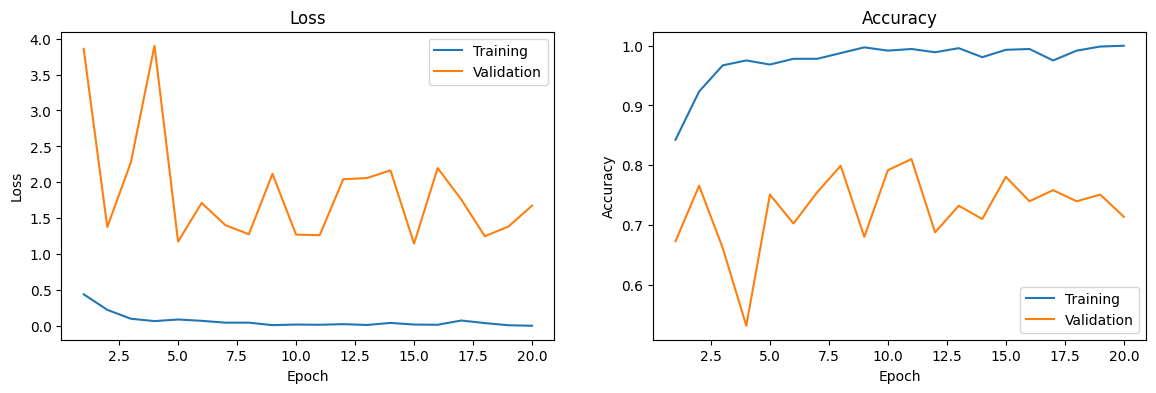

In [6]:
results = history.history
n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.legend()


plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')

plt.legend()
plt.show()

Model Evaluation

In [31]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = load_model('/content/xception_v1_11_0.810.h5')
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

9/9 - 3s - loss: 1.2630 - accuracy: 0.8104 - 3s/epoch - 372ms/step
Test accuracy: 81.04%


9/9 [==============================] - 3s 287ms/step


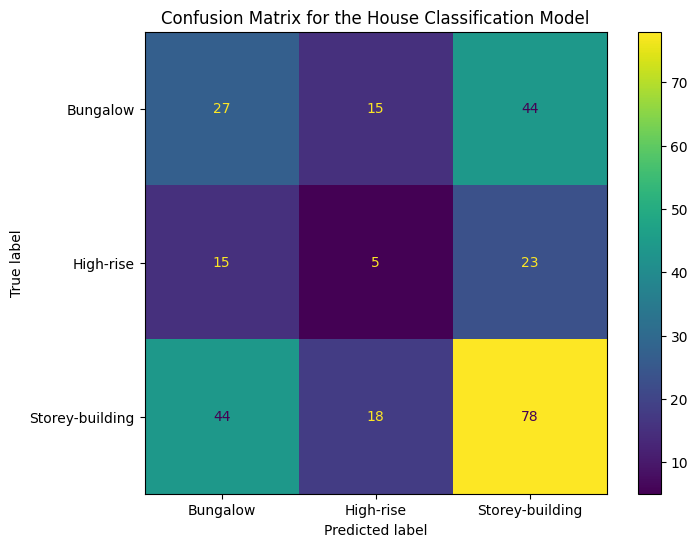

In [32]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

prediction = model.predict(validation_generator)
prediction = np.argmax(prediction, axis = 1)
conf_matrix = confusion_matrix(validation_generator.classes, prediction)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=list(validation_generator.class_indices.keys()))
ax.set(title='Confusion Matrix for the House Classification Model')

display.plot(ax=ax);